# Automatic Scoring with Machine Learning

This notebook explores classic machine learning algorithms with vectorized features from the student essays. 

In [9]:
# Import modules and setup notebook

%matplotlib inline

import numpy as np
import pandas as pd
import re
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.rcParams['figure.dpi']= 100

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
import warnings
warnings.filterwarnings("ignore")

# kappa metric for measuring agreement of automatic to human scores
from skll.metrics import kappa
from bhkappa import mean_quadratic_weighted_kappa

plt.style.use('seaborn-colorblind')

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', 100)

In [10]:
# Read essay data processed in previous notebook
training_set = pd.read_pickle('data/training_spacy.pkl')

In [12]:
training_set[['lemma', 'pos', 'ner']].sample(3)

,lemma,pos,ner
10635,"[there, be, many, reason, that, the, mooring, mast, could, not, be, use, ., the, first, reason, ...","[PRON, VERB, ADJ, NOUN, PRON, DET, NOUN, NOUN, AUX, PART, AUX, VERB, PUNCT, DET, ADJ, NOUN, AUX,...","[first, 1930, @ORGANIZATION1, Los Angeles, 1937, German, Hindenburg, thousands]"
7152,"[in, "", Narcs, Rodriguez, "", the, author, Narcs, Rodriguez, ,, write, a, memoir, about, his, chi...","[ADP, PUNCT, PROPN, PROPN, PUNCT, DET, NOUN, PROPN, PROPN, PUNCT, VERB, DET, NOUN, ADP, PRON, NO...","[Narcs Rodriguez, Narcs Rodriguez, Cuban, Cuban, Narcs, Narcs, Narcs, @CAPS1, Narcs, Narciso]"
6113,"[in, @CAPS1, Hibiscus, by, @PERSON1, ,, the, author, choose, the, last, paragraph, because, it,...","[ADP, PROPN, PROPN, ADP, PROPN, PUNCT, DET, NOUN, VERB, DET, ADJ, NOUN, SCONJ, PRON, VERB, DET, ...","[@CAPS1 Hibiscus, @PERSON1, winter, Sang, Vietnam, winter, season upon season, now., the same ..."


### Generate vectorized features from processed essays

A document similarity metric is available from *SpaCy*. In order to make use of it for essay scoring, we need to define a reference. Choosing an average, middle-scoring or aggregate essay would leave the sign of the difference undetermined: If the similarity is worse, does that mean the essay is better or worse? Choosing a low scoring essay would theoretically work, however many of the low scoring essays are very short and are full of spelling and grammatical errors. A high scoring essay would be best, though there is another point to consider. When an essay is written in a unique style, how will it compare? Since there are relatively few high scoring essays, the selection was performed manually and arbitrarily under consideration of a "representative style". 

The selection process remains highly subjective.

In [13]:
"""Choose arbitrary essay from highest available target_score for each topic.
all other essays will be compared to these. 
The uncorrected essays will be used since the reference essays should have fewer errors.
"""
reference_essays = {1: 161, 2: 3022, 3: 5263, 4: 5341, 5: 7209, 6: 8896, 7: 11796, 8: 12340} # topic: essay_id

references = {}

t0 = datetime.now()

nlp = spacy.load('en_core_web_sm')
stop_words = set(STOP_WORDS)

# generate nlp object for reference essays:
for topic, index in reference_essays.items():
    references[topic] = nlp(training_set.iloc[index]['essay'])

# generate document similarity for each essay compared to topic reference
training_set['similarity'] = training_set.apply(lambda row: nlp(row['essay']).similarity(references[row['topic']]), axis=1)

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

Processing time: 0:11:17.248698


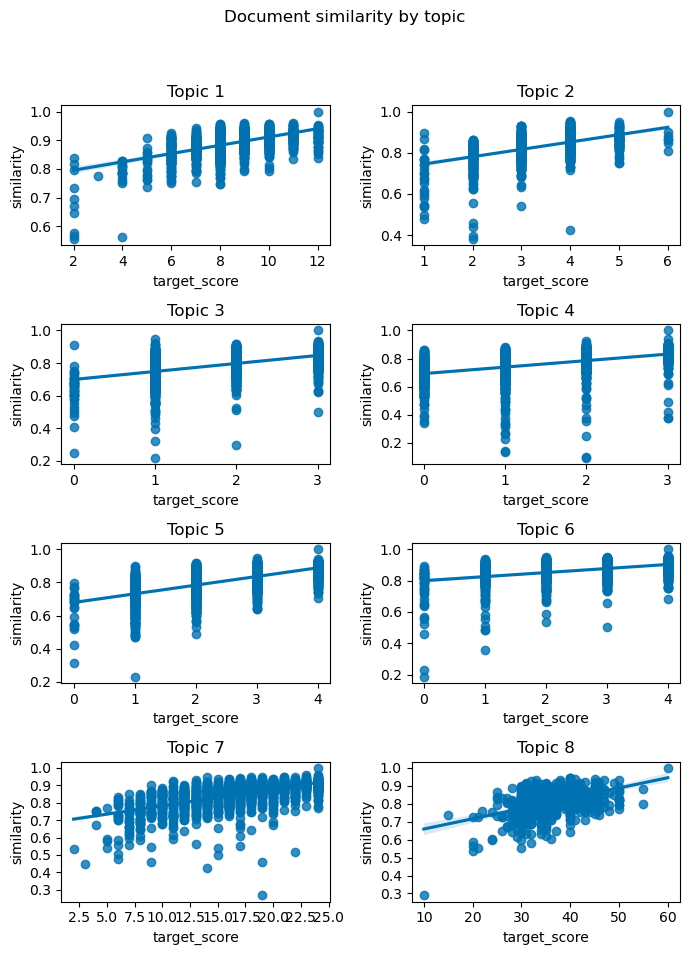

In [14]:
# Plot document similarity vs target score for each topic
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(7,10))
for i in range(4):
    for j in range(2):
        topic_number += 1
        sns.regplot(x='target_score', y='similarity', data=training_set[training_set['topic'] == topic_number], ax=ax[i,j])
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Document similarity by topic')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('image5.png', dpi=300)
plt.show()

Document similarity may prove to be ineffective for persuasive/narritive essays. The example below shows the highest scored essay for topic 8. The author uses a unique creative style which is unlikely to be replicated.

In [15]:
training_set.iloc[12340]['essay']

' Bell rings.  Shuffle, shuffle. @CAPS1. Snap. EEEE. Crack. Slam. Click, stomp, @CAPS1. Tap tap tap. SLAM. Creak. Shoof, shoof.  Sigh. Seventh class of the day. Here we go. "@CAPS2! Tu va ou pas? On a +¬tude cette class-l+á. Tu peux aller au bibliotheque si tu veux...." @CAPS3 all blinked at me, @PERSON1, @NUM1le and @ORGANIZATION1, chocolate-haired and mocha skinned, impatiently awaiting my answer. The truth was, I knew @CAPS3 didn\'t really care if I came or not. It made no difference to them if I trailed a few feet behind like some pathetic puppy. I was silent but adorable, loved only because I was an @CAPS4. Because I spoke fidgety @CAPS5. Because I was the exchange student, because my translator and colorful clothes were so shocking for ten seconds, and were then forgotten about.  I was a flock of seagulls haircut. So why are you here? I thought. Why did you go on exchange at all? You are the complete opposite of everyone here. No one wants you. Just go home.  But my ego had a rea

In [16]:
# count various features

t0 = datetime.now()

training_set['token_count'] = training_set.apply(lambda x: len(x['tokens']), axis=1)
training_set['unique_token_count'] = training_set.apply(lambda x: len(set(x['tokens'])), axis=1)
training_set['nostop_count'] = training_set \
            .apply(lambda x: len([token for token in x['tokens'] if token not in stop_words]), axis=1)
training_set['sent_count'] = training_set.apply(lambda x: len(x['sents']), axis=1)
training_set['ner_count'] = training_set.apply(lambda x: len(x['ner']), axis=1)
training_set['comma'] = training_set.apply(lambda x: x['corrected'].count(','), axis=1)
training_set['question'] = training_set.apply(lambda x: x['corrected'].count('?'), axis=1)
training_set['exclamation'] = training_set.apply(lambda x: x['corrected'].count('!'), axis=1)
training_set['quotation'] = training_set.apply(lambda x: x['corrected'].count('"') + x['corrected'].count("'"), axis=1)
training_set['organization'] = training_set.apply(lambda x: x['corrected'].count(r'@ORGANIZATION'), axis=1)
training_set['caps'] = training_set.apply(lambda x: x['corrected'].count(r'@CAPS'), axis=1)
training_set['person'] = training_set.apply(lambda x: x['corrected'].count(r'@PERSON'), axis=1)
training_set['location'] = training_set.apply(lambda x: x['corrected'].count(r'@LOCATION'), axis=1)
training_set['money'] = training_set.apply(lambda x: x['corrected'].count(r'@MONEY'), axis=1)
training_set['time'] = training_set.apply(lambda x: x['corrected'].count(r'@TIME'), axis=1)
training_set['date'] = training_set.apply(lambda x: x['corrected'].count(r'@DATE'), axis=1)
training_set['percent'] = training_set.apply(lambda x: x['corrected'].count(r'@PERCENT'), axis=1)
training_set['noun'] = training_set.apply(lambda x: x['pos'].count('NOUN'), axis=1)
training_set['adj'] = training_set.apply(lambda x: x['pos'].count('ADJ'), axis=1)
training_set['pron'] = training_set.apply(lambda x: x['pos'].count('PRON'), axis=1)
training_set['verb'] = training_set.apply(lambda x: x['pos'].count('VERB'), axis=1)
training_set['noun'] = training_set.apply(lambda x: x['pos'].count('NOUN'), axis=1)
training_set['cconj'] = training_set.apply(lambda x: x['pos'].count('CCONJ'), axis=1)
training_set['adv'] = training_set.apply(lambda x: x['pos'].count('ADV'), axis=1)
training_set['det'] = training_set.apply(lambda x: x['pos'].count('DET'), axis=1)
training_set['propn'] = training_set.apply(lambda x: x['pos'].count('PROPN'), axis=1)
training_set['num'] = training_set.apply(lambda x: x['pos'].count('NUM'), axis=1)
training_set['part'] = training_set.apply(lambda x: x['pos'].count('PART'), axis=1)
training_set['intj'] = training_set.apply(lambda x: x['pos'].count('INTJ'), axis=1)

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

Processing time: 0:00:06.070171


In [17]:
# save to file
training_set.to_pickle('data/training_features.pkl')

In [7]:
training_set = pd.read_pickle('data/training_features.pkl')

Index(['essay_id', 'topic', 'essay', 'rater1_domain1', 'rater2_domain1', 'rater3_domain1', 'target_score', 'rater1_domain2', 'rater2_domain2', 'topic2_target', 'rater1_trait1', 'rater1_trait2', 'rater1_trait3', 'rater1_trait4', 'rater1_trait5', 'rater1_trait6', 'rater2_trait1', 'rater2_trait2', 'rater2_trait3', 'rater2_trait4', 'rater2_trait5', 'rater2_trait6', 'rater3_trait1', 'rater3_trait2', 'rater3_trait3', 'rater3_trait4', 'rater3_trait5', 'rater3_trait6', 'corrected', 'tokens', 'lemma',
       'pos', 'sents', 'ner', 'similarity', 'token_count', 'unique_token_count', 'nostop_count', 'sent_count', 'ner_count', 'comma', 'question', 'exclamation', 'quotation', 'organization', 'caps', 'person', 'location', 'money', 'time', 'date', 'percent', 'noun', 'adj', 'pron', 'verb', 'cconj', 'adv', 'det', 'propn', 'num', 'part', 'intj'],
      dtype='object')


In [18]:
print(training_set.keys())

Index(['essay_id', 'topic', 'essay', 'rater1_domain1', 'rater2_domain1', 'rater3_domain1', 'target_score', 'rater1_domain2', 'rater2_domain2', 'topic2_target', 'rater1_trait1', 'rater1_trait2', 'rater1_trait3', 'rater1_trait4', 'rater1_trait5', 'rater1_trait6', 'rater2_trait1', 'rater2_trait2', 'rater2_trait3', 'rater2_trait4', 'rater2_trait5', 'rater2_trait6', 'rater3_trait1', 'rater3_trait2', 'rater3_trait3', 'rater3_trait4', 'rater3_trait5', 'rater3_trait6', 'corrected', 'tokens', 'lemma',
       'pos', 'sents', 'ner', 'similarity', 'token_count', 'unique_token_count', 'nostop_count', 'sent_count', 'ner_count', 'comma', 'question', 'exclamation', 'quotation', 'organization', 'caps', 'person', 'location', 'money', 'time', 'date', 'percent', 'noun', 'adj', 'pron', 'verb', 'cconj', 'adv', 'det', 'propn', 'num', 'part', 'intj'],
      dtype='object')


## Feature Selection

Many of the generated features are correlated with essay length. Collinearity is potentially an issue here.

KeyError: 'word_count'

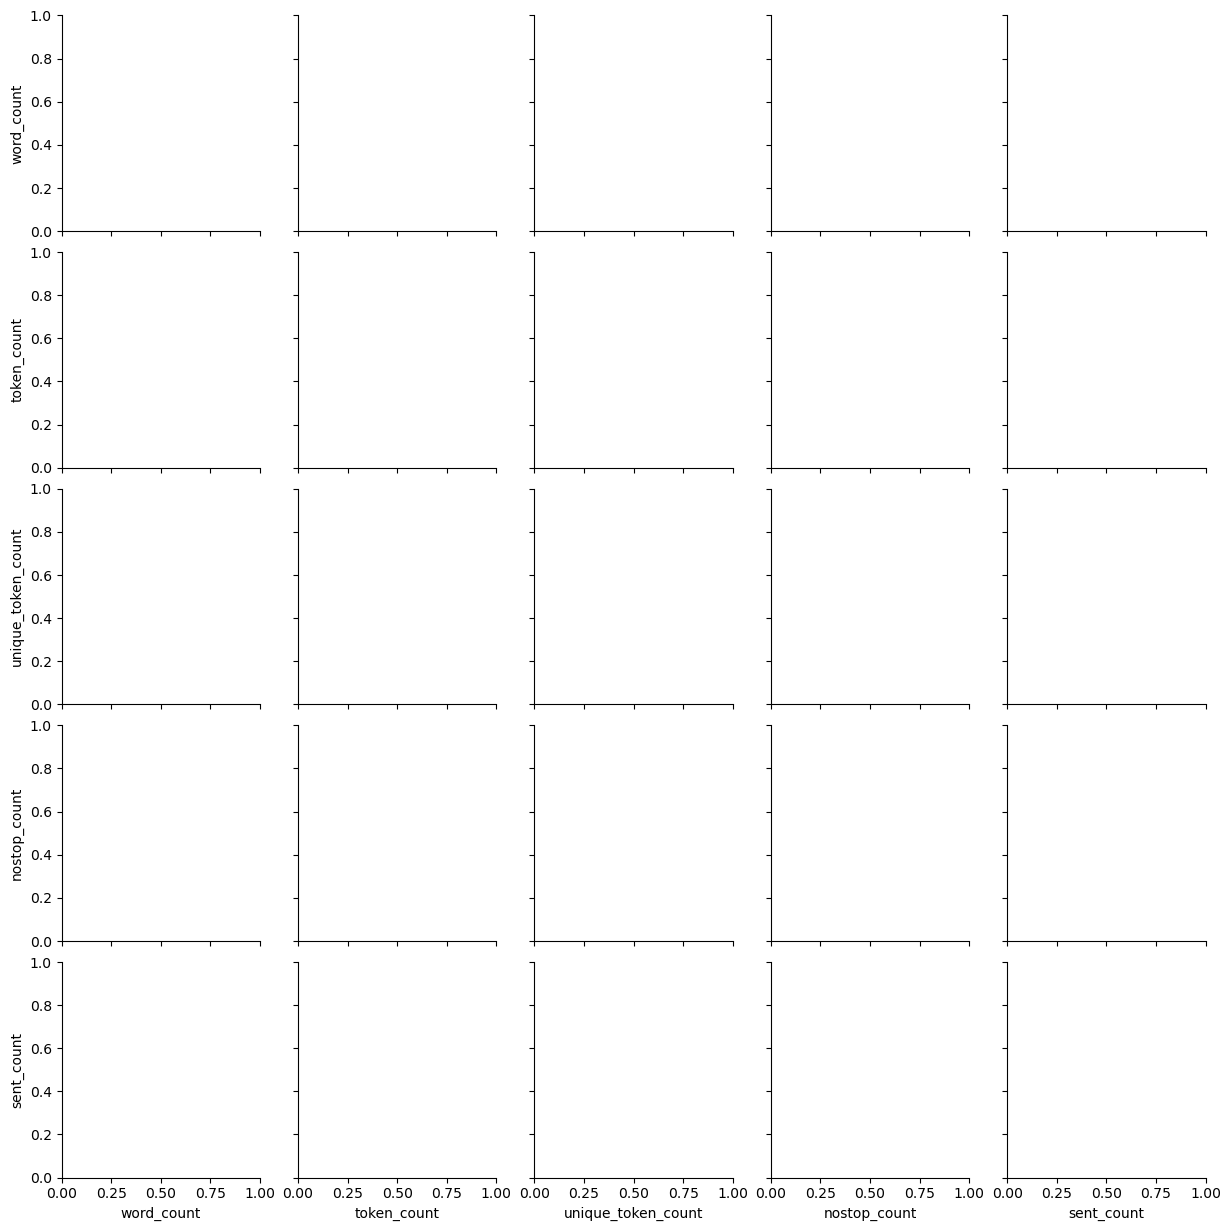

In [19]:
# Plot correlation of essay-length related features
usecols = ['word_count', 'token_count', 'unique_token_count', 'nostop_count', 'sent_count']
g = sns.pairplot(training_set[training_set.topic == 4], hue='target_score', vars=usecols, plot_kws={"s": 20}, palette="bright")
g.fig.subplots_adjust(top=.93)
g.fig.suptitle('Pairplots of select features', fontsize=16)
plt.show()

In [20]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 63 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   essay_id            12976 non-null  int64  
 1   topic               12976 non-null  int64  
 2   essay               12976 non-null  object 
 3   rater1_domain1      12976 non-null  int64  
 4   rater2_domain1      12976 non-null  int64  
 5   rater3_domain1      128 non-null    float64
 6   target_score        12976 non-null  int64  
 7   rater1_domain2      1800 non-null   float64
 8   rater2_domain2      1800 non-null   float64
 9   topic2_target       1800 non-null   float64
 10  rater1_trait1       2292 non-null   float64
 11  rater1_trait2       2292 non-null   float64
 12  rater1_trait3       2292 non-null   float64
 13  rater1_trait4       2292 non-null   float64
 14  rater1_trait5       723 non-null    float64
 15  rater1_trait6       723 non-null    float64
 16  rate

Incomplete columns are not used for modeling and can be ignored.

Univariate feature selection performed on the vectorized data shows few differences in the 10 best features by topic number. It is not surprising that `similarity` has little influence on `target_score` in topic 4 since there are only four unique scores and the the similarity by score plot above shows high variance.

In [41]:
# Selecting k best features: Some features omitted due to high correlation

predictors = [  
#                 'word_count',
#                'corrections',
                'similarity',
#                 'token_count',
                'unique_token_count',
#                 'nostop_count',
                'sent_count',
                'ner_count',
                'comma',
                'question',
                'exclamation',
                'quotation',
                'organization',
                'caps',
                'person',
                'location',
                'money',
                'time',
                'date',
                'percent',
                'noun',
                'adj',
                'pron',
                'verb',
                'cconj',
                'adv',
                'det',
                'propn',
                'num',
                'part',
                'intj'
                ]

# Create and fit selector
selector = SelectKBest(f_regression, k=10) # f_classif, chi2, f_regression, mutual_info_classif, mutual_info_regression

# Create empty dataframe
df = pd.DataFrame()

for topic in range(1, 9):
    kpredictors = []
    
    # test for division by zero errors due to insufficient data:
    for p in predictors:
        if np.std(training_set[training_set.topic == topic][p], axis=0) != 0:
            kpredictors.append(p)
            
    # select k best for each topic:
    X = training_set[training_set.topic == topic][kpredictors]
    y = training_set[training_set.topic == topic].target_score
    
    selector.fit(X, y)

    # Get idxs of columns to keep
    mask = selector.get_support(indices=True)

    selected_features = training_set[training_set.topic == topic][predictors].columns[mask]
    df["Topic " + str(topic)] = selected_features
df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,similarity,similarity,unique_token_count,unique_token_count,similarity,similarity,similarity,similarity
1,unique_token_count,unique_token_count,sent_count,sent_count,unique_token_count,unique_token_count,unique_token_count,unique_token_count
2,sent_count,sent_count,comma,comma,sent_count,sent_count,sent_count,sent_count
3,comma,comma,date,percent,date,comma,ner_count,ner_count
4,noun,noun,percent,noun,percent,date,noun,comma
5,adj,adj,noun,adj,noun,percent,adj,noun
6,verb,verb,adj,pron,adj,adj,pron,adj
7,cconj,adv,pron,verb,pron,verb,verb,verb
8,adv,det,verb,adv,verb,cconj,adv,adv
9,det,part,cconj,det,cconj,propn,det,det


Define the regression pipeline:

In [42]:
def evaluate(df, topic, features, model):
    """Regression pipeline with kappa evaluation"""

    X = df[df['topic'] == topic][features]
    y = df[df['topic'] == topic]['target_score'].astype(np.float64)
    # token_ct = X.token_count
    # X = X.div(token_ct, axis=0)
    # X['token_count'] = X['token_count'].mul(token_ct, axis=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)
    
    pipeline = Pipeline(model)
    pipeline.fit(X_train, y_train)

    
    y_pred = pipeline.predict(X_test)

    return kappa(y_pred, y_test, weights='quadratic')

An alternative feature selection strategy is to use **L1** regularization to limit the influence of less important features. This is implemented below in the ElasticNet regressor.

In [44]:
predictors = [  
                'word_count',
                #'corrections',
                'similarity',
                'token_count',
                'unique_token_count',
                'nostop_count',
                'sent_count',
                'ner_count',
                'comma',
                'question',
                'exclamation',
                'quotation',
                'organization',
                'caps',
                'person',
                'location',
                'money',
                'time',
                'date',
                'percent',
                'noun',
                'adj',
                'pron',
                'verb',
                'cconj',
                'adv',
                'det',
                'propn',
                'num',
                'part',
                'intj'
                ]

# feature selection
# fvalue_selector = SelectKBest(score_func=f_regression, k=10)

# for use in pipeline
models = [
            [('scaler', StandardScaler()),('linearSVC', LinearSVC(C=0.01))] ,
            [('scaler', StandardScaler()),('lm', LinearRegression())], 
            [('rf', RandomForestRegressor(random_state=26))],  
            [('en', ElasticNet(l1_ratio=0.01, alpha=0.1, max_iter=100000, random_state=26))] 
        ]

for steps in models:
    kappas = []
    weights = []
    for topic in range(1,9):
        kappas.append(evaluate(training_set, topic, predictors, steps))
        weights.append(len(training_set[training_set.topic==topic]))

    mqwk = mean_quadratic_weighted_kappa(kappas, weights=weights)
    print(steps)
    print('Weighted by topic Kappa score: {:.4f}'.format(mqwk))
    print('')

[('scaler', StandardScaler()), ('linearSVC', LinearSVC(C=0.01))]
Weighted by topic Kappa score: 0.5759

[('scaler', StandardScaler()), ('lm', LinearRegression())]
Weighted by topic Kappa score: 0.7151

[('rf', RandomForestRegressor(random_state=26))]
Weighted by topic Kappa score: 0.7099

[('en', ElasticNet(alpha=0.1, l1_ratio=0.01, max_iter=100000, random_state=26))]
Weighted by topic Kappa score: 0.7072



Of the four models on which the data was evaluated, the three regression models returned very similar mean weighted kappa scores and the simple linear regression model slightly outperformed the others. The support vector classifier performed poorly. 

Can we improve on the hyperparameters for ElasticNet by running GridSearchCV on each topic?

In [45]:
# ElasticNet with GridSearchCV for each individual topic

def en_evaluate(df, topic, features):
    # Regression pipeline with kappa evaluation
    paramgrid = {'l1_ratio': [.01, .1, .3, .5, .7, .99], 'alpha': [0.001, 0.01, 0.1, 1]}
    X = df[df['topic'] == topic][features]
    y = df[df['topic'] == topic]['target_score'].astype(np.float64)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)
    
    gs = GridSearchCV(ElasticNet(max_iter=100000, random_state=26),
                      param_grid=paramgrid,
                      cv=5)
    gs.fit(X_train, y_train)
    print('Topic', topic, 'best parameters:', gs.best_params_)
    y_pred = gs.predict(X_test)

    return kappa(y_pred, y_test, weights='quadratic')

In [46]:
kappas = []
weights = []
for topic in range(1,9):
    kappas.append(en_evaluate(training_set, topic, predictors))
    weights.append(len(training_set[training_set.topic==topic]))
    
mqwk = mean_quadratic_weighted_kappa(kappas, weights=weights)
print('Weighted by topic Kappa score: {:.4f}'.format(mqwk))

Topic 1 best parameters: {'alpha': 0.001, 'l1_ratio': 0.99}
Topic 2 best parameters: {'alpha': 0.001, 'l1_ratio': 0.99}
Topic 3 best parameters: {'alpha': 0.1, 'l1_ratio': 0.3}
Topic 4 best parameters: {'alpha': 0.01, 'l1_ratio': 0.5}
Topic 5 best parameters: {'alpha': 0.001, 'l1_ratio': 0.99}
Topic 6 best parameters: {'alpha': 0.001, 'l1_ratio': 0.01}
Topic 7 best parameters: {'alpha': 0.001, 'l1_ratio': 0.7}
Topic 8 best parameters: {'alpha': 0.001, 'l1_ratio': 0.99}
Weighted by topic Kappa score: 0.7097


A low `l1_ratio` implies Ridge regression with **l2** regularization. The weighted Kappa score did not improve measurably when hyperparameters are tuned for each topic, including cross-validation.

In [47]:
# Individual topic kappa scores
kappas

[0.8034608125055421,
 0.6164772727272727,
 0.6656107332525855,
 0.6075161987041037,
 0.7889190026943467,
 0.6965246974721158,
 0.7431727784531494,
 0.6940704356480144]

A final approach for feature selection is to extract the Gini-importances of random forests:

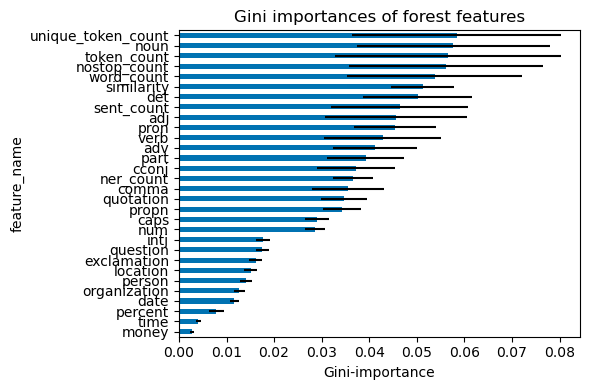

In [49]:
X = training_set[predictors]
y = training_set['target_score'].astype(np.float64)


forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=26)

forest.fit(X, y)

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# plot feature importances

features = pd.DataFrame({'feature_name': X.columns, 'importance': forest.feature_importances_, 'std': std})
features.sort_values('importance')\
        .plot.barh(x='feature_name', y='importance', xerr='std', legend=False)
plt.title('Gini importances of forest features')
plt.xlabel('Gini-importance')
plt.tight_layout()
plt.show()

In [50]:
# best k features
k = 15
top_features = features.sort_values('importance', ascending=False)['feature_name'].tolist()[:k]

# Linear regression with top k features
kappas = []
weights = []
steps = [('scaler', StandardScaler()),('lm', LinearRegression())]
for topic in range(1,9):
    kappas.append(evaluate(training_set, topic, top_features, steps))
    weights.append(len(training_set[training_set.topic==topic]))

mqwk = mean_quadratic_weighted_kappa(kappas, weights=weights)
print('Weighted by topic Kappa score: {:.4f}'.format(mqwk))

Weighted by topic Kappa score: 0.7112


The kappa scores increase with increasing number of features.

As shown earlier and in the correlation matrix below, some features are highly correlated. This can lead to problems if there are insufficient observations to explain the differences between features. Signs of potential collinearity problems could be poor generalization of the model. In this case, the Kappa scores did not change dramatically when using training and test data or when applying cross-validation.

Models that apply feature selection might automatically remove some highly correlated features.

/var/folders/b3/h5x9g13j4lv3wmnb5gjp50yh0000gn/T/ipykernel_2520/2196982227.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


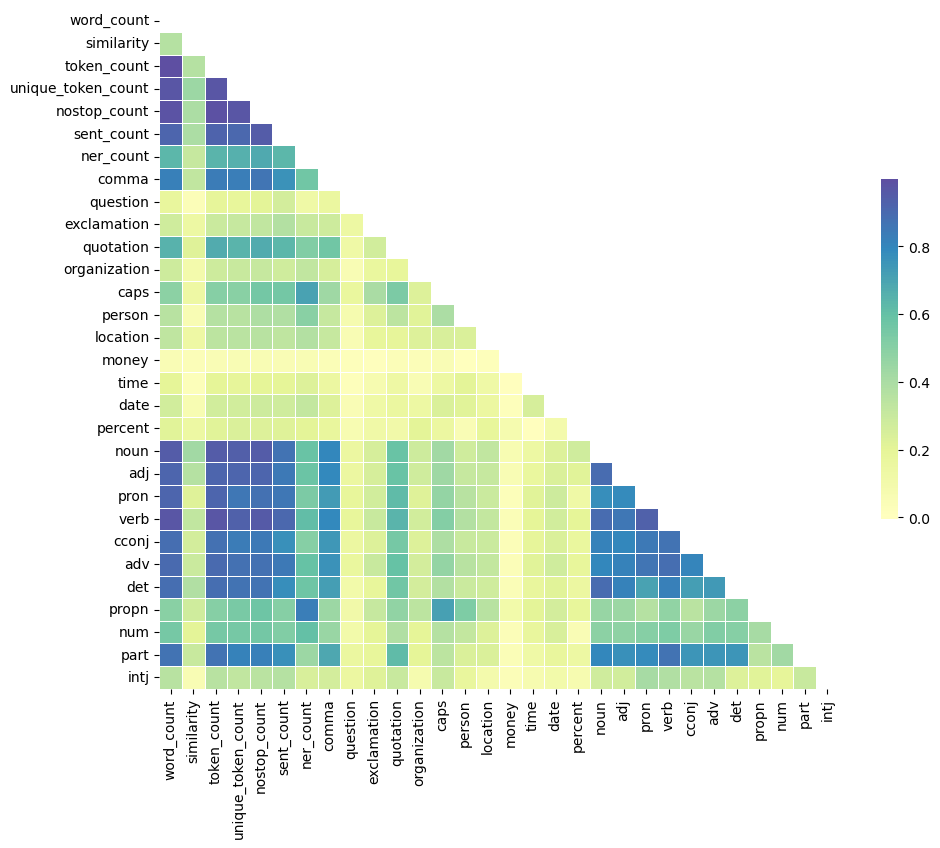

In [51]:
# Overview of correlating features
corr = training_set[predictors].corr() # default: Pearson
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(corr, mask=mask, cmap='Spectral', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()


### Adding TF-IDF features

In [52]:
# Lemmatized essays re-joined (list to essay)
training_set['l_essay'] = training_set['lemma'].apply(' '.join)

vectorizer = TfidfVectorizer(max_df=.2, 
                             min_df=3, 
                             max_features=2000,
                             stop_words=STOP_WORDS) # default: binary=False
tfidf_matrix = vectorizer.fit_transform(training_set.l_essay) # using lemmatized essays
tfidf_matrix.shape

/usr/local/Caskroom/miniforge/base/envs/myenv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(12976, 2000)

In [53]:
training_set[predictors].shape

(12976, 30)

In [54]:
# Combine previous predictors with TF-IDF matrix
combined_dense = pd.concat([pd.DataFrame(tfidf_matrix.todense()), 
                            training_set[predictors], 
                            training_set['topic'], 
                            training_set['target_score']], axis=1)
combined_dense.shape

(12976, 2032)

In [55]:
# ElasticNet with GridSearchCV for each individual topic

def tf_evaluate(df, topic):
    # Regression pipeline with kappa evaluation
    paramgrid = {'l1_ratio': [.01, .1, .5, .9], 'alpha': [0.01, .1, 1]}
    X = df[df['topic'] == topic].drop(['topic', 'target_score'], axis=1)
    y = df[df['topic'] == topic]['target_score'].astype(np.float64)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=26)
    
    gs = GridSearchCV(ElasticNet(max_iter=100000, random_state=26),
                      param_grid=paramgrid,
                      cv=5)
    gs.fit(X_train, y_train)
    print('Topic', topic, 'best parameters:', gs.best_params_)
    y_pred = gs.predict(X_test)

    return kappa(y_pred, y_test, weights='quadratic')

In [57]:

# ElasticNet with GridSearchCV for each individual topic

kappas = []
weights = []
for topic in range(1,9):
    kappas.append(tf_evaluate(combined_dense, topic))
    weights.append(len(training_set[training_set.topic==topic]))
    
mqwk = mean_quadratic_weighted_kappa(kappas, weights=weights)
print('Weighted by topic Kappa score: {:.4f}'.format(mqwk))

Topic 1 best parameters: {'alpha': 1, 'l1_ratio': 0.5}
Topic 2 best parameters: {'alpha': 0.01, 'l1_ratio': 0.01}
Topic 3 best parameters: {'alpha': 0.01, 'l1_ratio': 0.01}
Topic 4 best parameters: {'alpha': 0.01, 'l1_ratio': 0.01}
Topic 5 best parameters: {'alpha': 0.01, 'l1_ratio': 0.01}
Topic 6 best parameters: {'alpha': 0.01, 'l1_ratio': 0.01}
Topic 7 best parameters: {'alpha': 0.01, 'l1_ratio': 0.9}
Topic 8 best parameters: {'alpha': 1, 'l1_ratio': 0.5}
Weighted by topic Kappa score: 0.7312


Adding TF-IDF features only marginally improved the kappa score